# DBSCAN Project 

## The Data


Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Provide all relevant information about your data set.


Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

Relevant Papers:

Cardoso, Margarida G.M.S. (2013). Logical discriminant models â€“ Chapter 8 in Quantitative Modeling in Marketing and Management Edited by Luiz Moutinho and Kun-Huang Huarng. World Scientific. p. 223-253. ISBN 978-9814407717

Jean-Patrick Baudry, Margarida Cardoso, Gilles Celeux, Maria JosÃ© Amorim, Ana Sousa Ferreira (2012). Enhancing the selection of a model-based clustering with external qualitative variables. RESEARCH REPORT NÂ° 8124, October 2012, Project-Team SELECT. INRIA Saclay - ÃŽle-de-France, Projet select, UniversitÃ© Paris-Sud 11



-----


## 1. Imports and Data Loading

Let's start by importing the necessary libraries and loading the dataset.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from pandas.plotting import parallel_coordinates
import joblib

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# Load the dataset
df = pd.read_csv('DATA/wholesome_customers_data.csv')


In [3]:
# Display the first few rows
df.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## Exploratory Data Analysis (EDA)

In this section, we perform an exploratory analysis of the customer dataset to understand its structure, identify patterns, and detect any anomalies or outliers. EDA helps uncover relationships between features, guides preprocessing decisions, and informs the selection of appropriate clustering parameters for DBSCAN.

We will examine summary statistics, visualize feature distributions, and explore relationships between key variables to gain insights into the data before applying clustering algorithms.

### MILK vs. GROCERY Spending by Channel

This scatter plot visualizes the relationship between customer spending on MILK and GROCERY, with points colored by the `Channel` column.

Comparing these two spending categories across channels can reveal differences in purchasing patterns and help identify distinct customer groups.

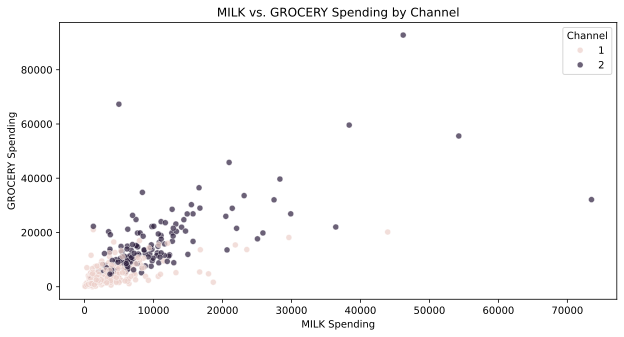

In [5]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x='Milk',
    y='Grocery',
    hue='Channel',
    alpha=0.7,
    linewidth=0.5
)
plt.title('MILK vs. GROCERY Spending by Channel')
plt.xlabel('MILK Spending')
plt.ylabel('GROCERY Spending')
plt.legend(title='Channel')
plt.savefig('visualisations/milk_grocery_channel.svg')

### Customer Count by Region (Bar Plot)

This bar plot displays the number of customers in each region. It helps to understand the distribution of customers geographically, which is useful for market segmentation and resource allocation.

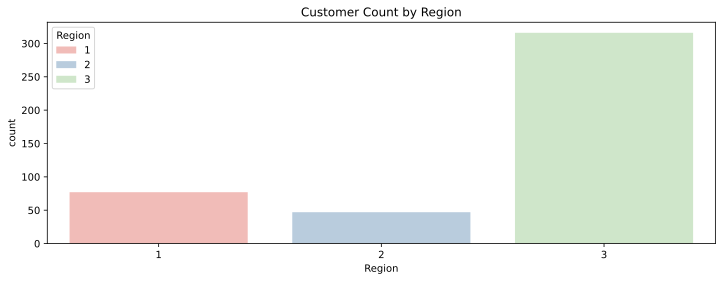

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x='Region',hue="Region", palette='Pastel1')
plt.title('Customer Count by Region')
plt.show()
plt.savefig('visualisations/customer_count_by_region.svg');

### Average Grocery Spending by Channel and Region (Heatmap)

This heatmap shows the average `Grocery` spending for each combination of channel and region. It allows for easy identification of which customer segments (by channel and region) tend to spend more or less on groceries.

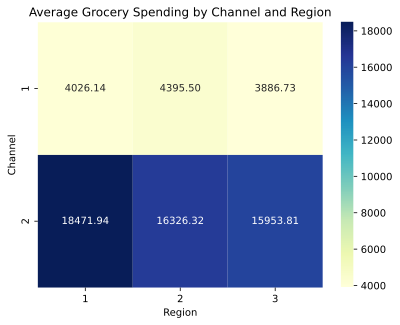

In [7]:
pivot = df.pivot_table(index='Channel', columns='Region', values='Grocery', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu')  # fmt=".0f" for integer formatting
plt.title('Average Grocery Spending by Channel and Region')
plt.savefig('visualisations/grocery_channel_region.svg')

### Grocery Spending by Channel (Boxplot)

This boxplot compares the distribution of `Grocery` spending across different sales channels. It helps reveal whether certain channels are associated with higher or lower average grocery purchases, and highlights the spread and presence of outliers within each channel group.

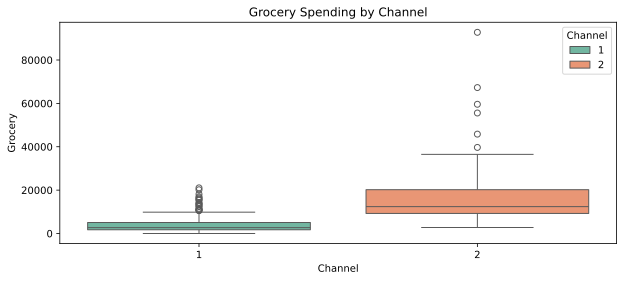

In [8]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x='Channel', y='Grocery',hue='Channel', palette='Set2')
plt.title('Grocery Spending by Channel')
plt.savefig('visualisations/grocery_channel.svg');

### Distribution of MILK Spending by Channel

This histogram shows the distribution of MILK spending for each channel. The bars are stacked to display the contribution of each channel to the overall distribution, making it easy to compare the spending patterns across channels.


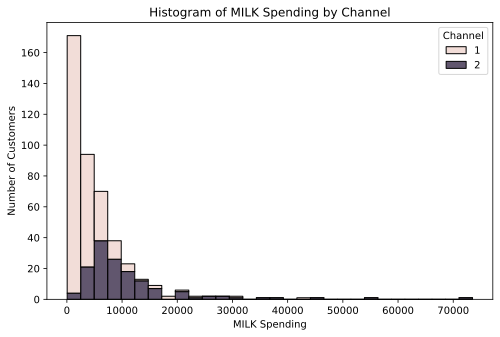

In [9]:

plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x='Milk',
    hue='Channel',
    multiple='stack', 
    bins=30,
    edgecolor='black'
)
plt.title('Histogram of MILK Spending by Channel')
plt.xlabel('MILK Spending')
plt.ylabel('Number of Customers')
plt.savefig('visualisations/milk_channel.svg')


###  Milk Spending Distribution by Region (Violin Plot)

The violin plot below displays the distribution and density of `Milk` spending for each region. This visualization provides insights into how customer purchasing habits for milk vary across regions, including differences in central tendency and spread.

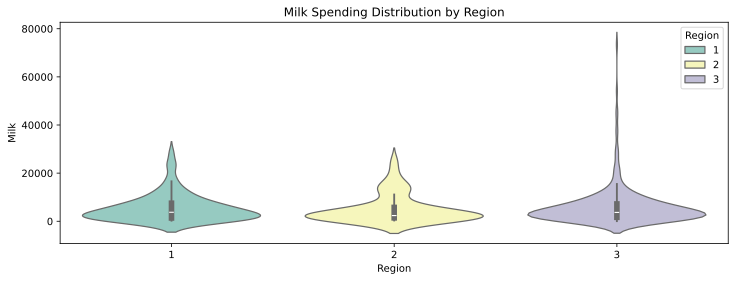

In [10]:
plt.figure(figsize=(12,4))
sns.violinplot(data=df, x='Region', y='Milk',hue= 'Region', palette='Set3')
plt.title('Milk Spending Distribution by Region')
plt.savefig('visualisations/milk_region.svg')


### Correlation Matrix of Numerical Features (Heatmap)

The heatmap below visualizes the pairwise correlations between all numerical features in the dataset. Strong correlations may indicate redundant features or underlying relationships that could influence clustering results.

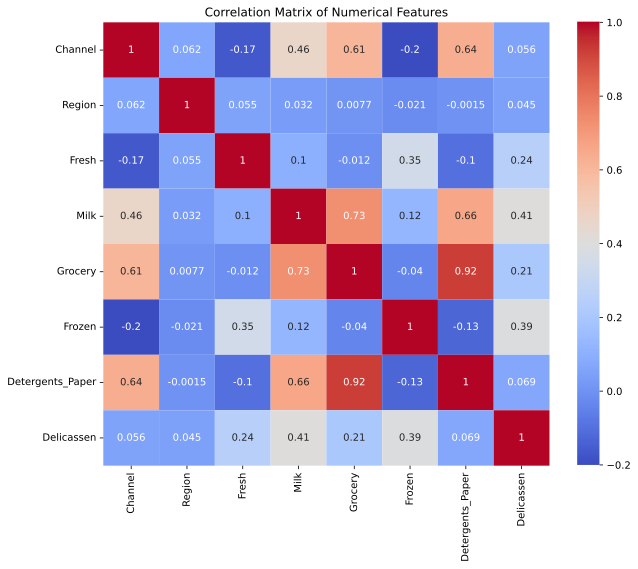

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('visualisations/correlation_matrix.svg')

### Clustermap of Spending Category Correlations

This annotated clustermap visualizes the correlation matrix between different spending categories. Features that are highly correlated are grouped together, making it easy to spot patterns and potential redundancies in customer spending behavior.

Correlation Between Spending Categories


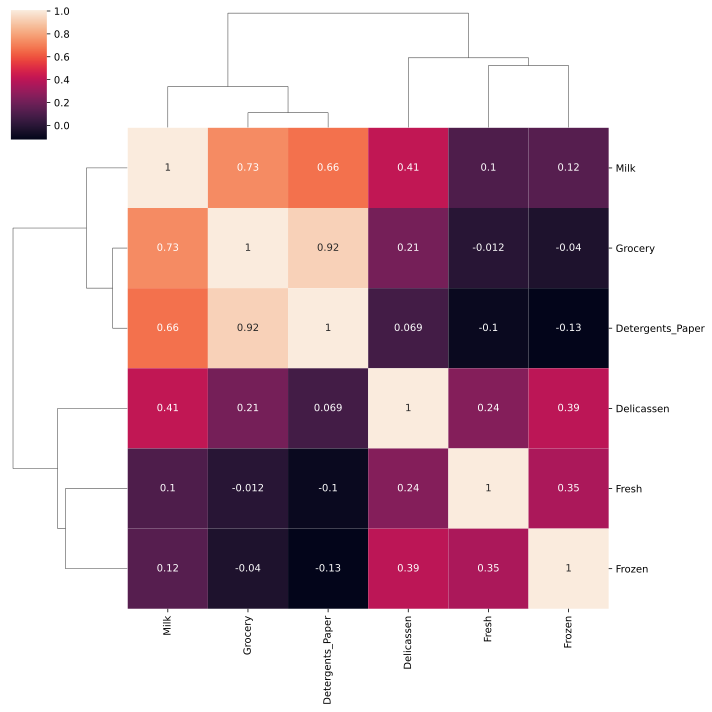

In [12]:
print('Correlation Between Spending Categories')
sns.clustermap(df.drop(['Region','Channel'],axis=1).corr(),annot=True)
plt.savefig('visualisations/clustermap.svg');

### Pairplot of Spending Features by Region

This pairplot visualizes pairwise relationships between numerical features in the dataset, with points colored by the `Region` column. This helps to identify patterns, clusters, and potential separability of customer groups across different regions.

In [13]:
sns.pairplot(df,hue='Region',palette='Set1')
plt.savefig('visualisations/pairplot.svg')

## DBSCAN

Before applying the DBSCAN clustering algorithm, it is important to scale the feature data. This is because DBSCAN uses distance metrics to identify clusters, and features measured on different scales can bias the results. 

We will use `StandardScaler` to standardize the features so that each has a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the clustering process, regardless of their original units or magnitude.

In [14]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df)

In [15]:
scaled_X

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

### DBSCAN Epsilon Tuning and Outlier Detection

To understand how the choice of epsilon affects DBSCAN clustering, we systematically test a range of epsilon values using a for loop. For each run:

- `min_samples` is set to twice the number of features.
- We fit DBSCAN with the current epsilon value and record the percentage of points labeled as outliers (noise).
- The process is repeated for epsilon values in the range `np.linspace(0.001, 3, 50)`.

Tracking the outlier percentage across different epsilon values helps identify a suitable range for effective clustering and highlights the sensitivity of DBSCAN to this parameter.

In [16]:
outlier_percent = []
eps_values = np.linspace(0.001,3,50)
for eps in eps_values:
    
    # Create Model
    dbscan = DBSCAN(eps=eps,min_samples=2*scaled_X.shape[1])
    dbscan.fit(scaled_X)
   
     
    # Log percentage of points that are outliers
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

### Outlier Percentage vs. Epsilon Value

The line plot below shows how the percentage of outlier (noise) points identified by DBSCAN changes as the epsilon parameter varies. This visualization helps pinpoint epsilon values that balance cluster formation with minimizing the number of points classified as noise.

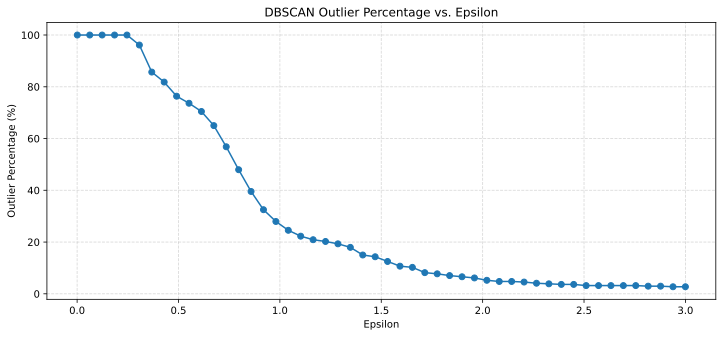

In [17]:
plt.figure(figsize=(12,5))
plt.plot(eps_values, outlier_percent, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Outlier Percentage (%)')
plt.title('DBSCAN Outlier Percentage vs. Epsilon')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('visualisations/dbscan_outlier_percentage.svg')

## DBSCAN with Chosen Epsilon

Based on the outlier percentage plot, we now retrain the DBSCAN model using a selected epsilon value.

In [18]:
# Use eps=2 and min_samples as before
chosen_eps = 2
min_samples = 2 * scaled_X.shape[1]

dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)
labels = dbscan.fit_predict(scaled_X)

# Attach cluster labels to the DataFrame for further analysis
df['DBSCAN_Cluster'] = labels

# Display the number of clusters and outliers
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = np.sum(labels == -1)
print(f"Number of clusters found: {n_clusters}")
print(f"Number of outliers (noise points): {n_outliers}")

Number of clusters found: 2
Number of outliers (noise points): 25


### Milk vs. Grocery Spending by DBSCAN Cluster

This scatter plot visualizes the relationship between `Milk` and `Grocery` spending, with points colored according to the cluster labels assigned by the DBSCAN algorithm. Outliers (noise points) are typically labeled as `-1` and shown in a distinct color.

This plot helps reveal how DBSCAN has grouped customers based on their spending patterns in these two categories.

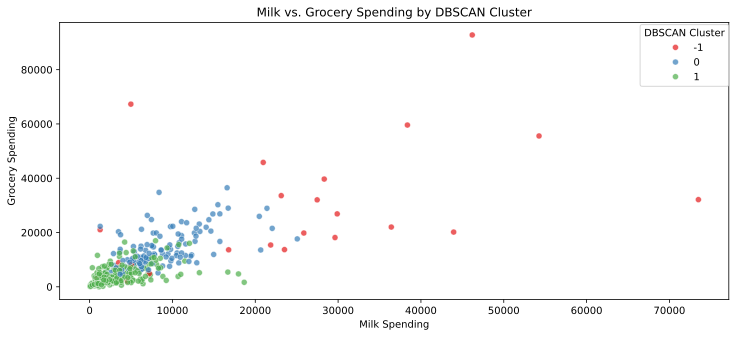

In [19]:
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=df,
    x='Milk',
    y='Grocery',
    hue='DBSCAN_Cluster',
    palette='Set1',
    alpha=0.7,
    linewidth=0.5
)
plt.title('Milk vs. Grocery Spending by DBSCAN Cluster')
plt.xlabel('Milk Spending')
plt.ylabel('Grocery Spending')
plt.legend(title='DBSCAN Cluster', bbox_to_anchor=(0.86, 1.01), loc='upper left')
plt.savefig('visualisations/dbscan_milk_grocery.svg')

### Milk vs. Detergents Paper by DBSCAN Cluster

This scatter plot shows how customers are grouped by DBSCAN based on their spending on `Milk` and `Detergents_Paper`.

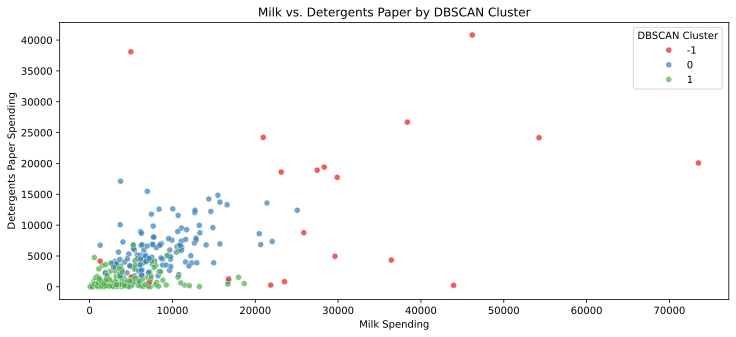

In [20]:
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=df,
    x='Milk',
    y='Detergents_Paper',
    hue='DBSCAN_Cluster',
    palette='Set1',
    alpha=0.7,
    linewidth=0.5
)
plt.title('Milk vs. Detergents Paper by DBSCAN Cluster')
plt.xlabel('Milk Spending')
plt.ylabel('Detergents Paper Spending')
plt.legend(title='DBSCAN Cluster', bbox_to_anchor=(0.85, 1), loc='upper left')
plt.savefig('visualisations/dbscan_milk_detergents.svg')

A new column called `"Labels"` is added to the DataFrame to store the cluster assignments generated by the DBSCAN algorithm. Each row now includes its corresponding cluster label, with outliers labeled as `-1`.

In [21]:
df['Labels'] = dbscan.labels_

### Swarm Plot of Grocery Spending by Cluster

This swarm plot displays the distribution and density of `Grocery` spending within each DBSCAN cluster, helping to reveal differences in spending behavior across groups.

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


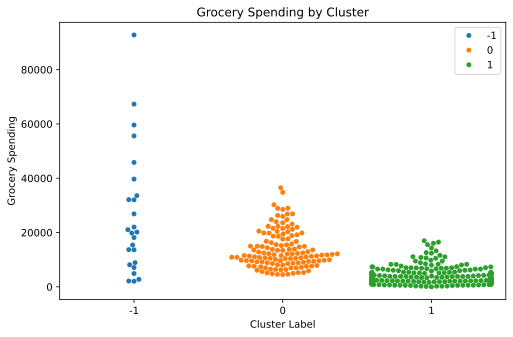

In [22]:
plt.figure(figsize=(8,5))
sns.swarmplot(data=df, x='Labels', y='Grocery',hue=dbscan.labels_, palette='tab10')
plt.title('Grocery Spending by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Grocery Spending')
plt.savefig('visualisations/grocery_spending_by_cluster.svg')

### Parallel Coordinates Plot of Cluster Profiles

The parallel coordinates plot below shows the profile of each cluster across all spending categories. Each line represents a cluster, making it easy to compare feature patterns between clusters.

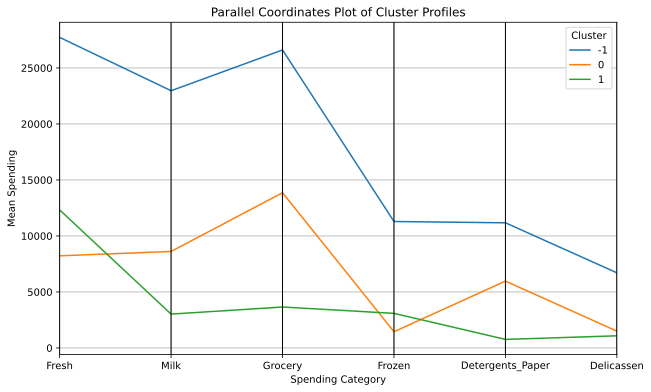

In [23]:
# Compute mean spending per cluster
spending_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
cluster_means = df.groupby('Labels')[spending_cols].mean().reset_index()

plt.figure(figsize=(10,6))
parallel_coordinates(cluster_means, 'Labels', color=sns.color_palette('tab10', n_colors=len(cluster_means)))
plt.title('Parallel Coordinates Plot of Cluster Profiles')
plt.xlabel('Spending Category')
plt.ylabel('Mean Spending')
plt.legend(title='Cluster')
plt.savefig('visualisations/parallel_coordinates.svg')

### Radar Chart of Mean Spending per Cluster

This radar chart provides a compact, visual summary of mean spending patterns for each cluster across all categories.

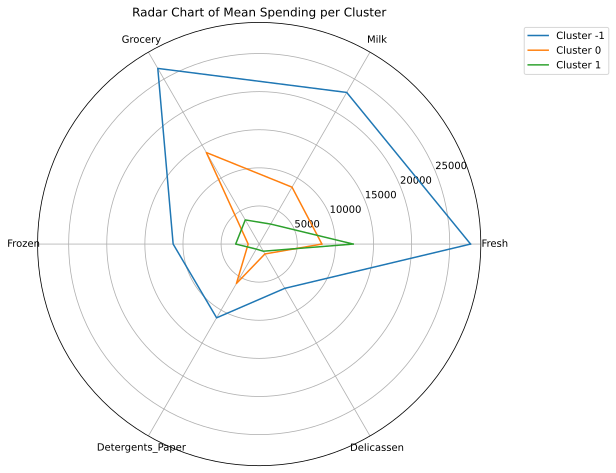

In [24]:
# Prepare data
categories = spending_cols
N = len(categories)
cluster_means = df.groupby('Labels')[categories].mean()

# Radar chart for each cluster
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(8,8))
for label, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {label}')
plt.xticks(angles[:-1], categories)
plt.title('Radar Chart of Mean Spending per Cluster')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.savefig('visualisations/radar_chart.svg')

### Pie Chart of Cluster Sizes

This pie chart illustrates the proportion of customers in each cluster, including outliers, to show the distribution of the segmentation.

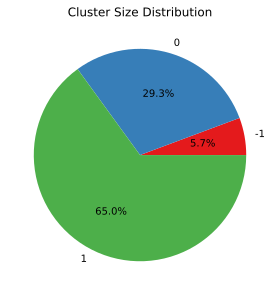

In [25]:
cluster_counts = df['Labels'].value_counts().sort_index()
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set1', n_colors=len(cluster_counts)))
plt.title('Cluster Size Distribution')
plt.savefig('visualisations/cluster_size_distribution.svg')

### Bar Plot of Cluster Counts by Region

This bar plot compares how clusters are distributed across different regions, revealing geographic patterns in customer segmentation.

To compare the clusters identified by DBSCAN, we calculate and examine the mean spending amounts for each category within every cluster, including the outlier group (`-1`). This comparison highlights how spending behavior differs between the main customer segments and the outliers detected by the algorithm.

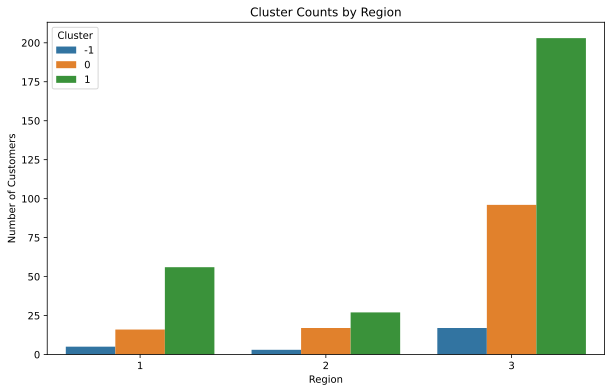

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Region', hue='Labels', palette='tab10')
plt.title('Cluster Counts by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.legend(title='Cluster')
plt.savefig('visualisations/cluster_counts_by_region.svg')

In [27]:
cats = df.drop(['Channel','Region'],axis=1)
cat_means = cats.groupby('Labels').mean()

In [28]:
# Compute mean spending per cluster
cat_means

Fresh          Milk       Grocery        Frozen  \
Labels                                                           
-1      27729.920000  22966.960000  26609.600000  11289.640000   
 0       8227.666667   8615.852713  13859.674419   1447.759690   
 1      12326.972028   3023.559441   3655.328671   3086.181818   

        Detergents_Paper   Delicassen  DBSCAN_Cluster  
Labels                                                 
-1          11173.560000  6707.160000            -1.0  
 0           5969.581395  1498.457364             0.0  
 1            763.783217  1083.786713             1.0

To facilitate comparison across spending categories, we normalize the mean spending values for each cluster using MinMaxScaler, scaling all values to the range 0–1. The resulting heatmap provides a clear visual summary of relative spending patterns among clusters and outliers.

In [29]:
scaler = MinMaxScaler()
data = scaler.fit_transform(cat_means)
scaled_means = pd.DataFrame(data,cat_means.index,cat_means.columns)

In [30]:
scaled_means

Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen  \
Labels                                                                         
-1      1.000000  1.000000  1.000000  1.000000          1.000000    1.000000   
 0      0.000000  0.280408  0.444551  0.000000          0.500087    0.073741   
 1      0.210196  0.000000  0.000000  0.166475          0.000000    0.000000   

        DBSCAN_Cluster  
Labels                  
-1                 0.0  
 0                 0.5  
 1                 1.0

### Normalized Mean Spending per Cluster

The heatmap below displays the normalized mean spending values for each cluster (including outliers) across all spending categories. This visualization makes it easy to compare the relative spending patterns and identify distinctive characteristics of each group.

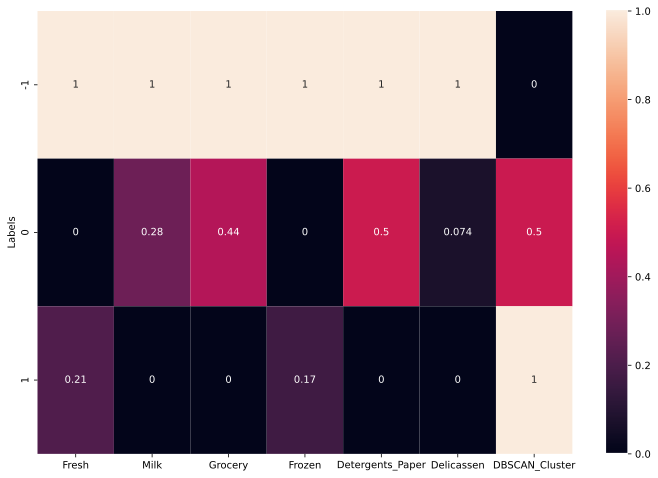

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(scaled_means,annot=True)
plt.savefig('visualisations/scaled_means_correlation.svg')

### Normalized Mean Spending per Cluster (Outliers Removed)

This heatmap displays the normalized mean spending values for each cluster, excluding the outlier group. By focusing on the main clusters, we can more clearly observe

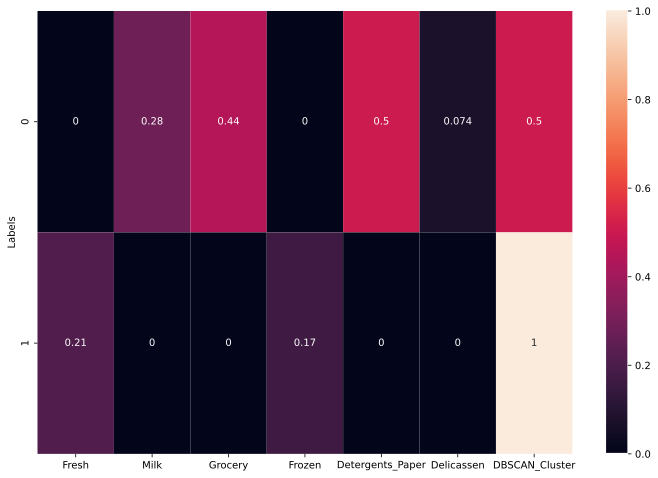

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(scaled_means.loc[[0,1]],annot=True)
plt.savefig('visualisations/scaled_means_correlation.svg')

**To determine which spending category most distinguishes the two main clusters, examine the heatmap and compare the normalized mean values across categories. The category with the largest difference between clusters is the one where their spending behavior diverges the most.**

We can see that Detergents Paper was the most significant difference.

## Model Persistence

To ensure that trained models can be easily reused without retraining, we use the `joblib` library for model persistence. `joblib` allows us to efficiently save and load scikit-learn models (and other Python objects) to disk. This enables seamless deployment, sharing, and future evaluation of our models.

Typical workflow:
- After training a model, save it to a file using `joblib.dump`.
- Later, load the model back into memory with `joblib.load` for making predictions or further analysis.

This approach is especially useful for production environments or when working with large datasets and complex models.

### Saving and Loading Models with joblib

After training your model, you can save it to disk using `joblib.dump`:


**Note: For reproducibility and consistent predictions, it's important to save not only your trained model but also any preprocessing objects such as scalers. This ensures that new data is transformed in the same way as the training data.**



In [33]:
# Save the trained model to a file
joblib.dump(scaler, 'models/DBSCAN_scaler.joblib')
joblib.dump(dbscan, 'models/DBSCAN.joblib')

['models/DBSCAN.joblib']

In [34]:
# Load the model from the file
loaded_model = joblib.load('models/DBSCAN.joblib')

## Conclusion

In this project, we applied DBSCAN clustering to segment customers based on their spending patterns across multiple categories. Through careful exploratory data analysis and systematic tuning of DBSCAN’s parameters, we identified distinct customer groups and outliers.

Key findings include:
- DBSCAN effectively detected natural clusters in the data without needing to pre-specify the number of clusters.
- Outlier detection highlighted atypical spending behaviors that may warrant further investigation.
- Visualizations such as scatterplots, heatmaps, and radar charts provided valuable insights into the unique characteristics of each cluster.
- Comparing cluster profiles revealed which spending categories most differentiated customer groups, supporting targeted business strategies.

This unsupervised approach offers a foundation for deeper customer understanding and can be extended or combined with supervised learning for even richer insights.